<a href="https://colab.research.google.com/github/MaYuetong/MaYuetong/blob/main/%E2%80%9C%E2%80%9Clgb_qt_dntl_ipynb%E2%80%9D%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git
!pip install shap
!pip install skopt
!pip install PyALE

Mounted at /content/drive
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2570k  100 2570k    0     0  8798k      0 --:--:-- --:--:-- --:--:-- 8803k
  Cloning https://github.com/scikit-optimize/scikit-optimize.git to /tmp/pip-req-build-he49pk2s
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-optimize/scikit-optimize.git /tmp/pip-req-build-he49pk2s
  Resolved https://github.com/scikit-optimize/scikit-optimize.git to commit a2369ddbc332d16d8ff173b12404b03fea472492
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pyaml-23.9.7-py3-none-any.whl (23 kB)
  Created wheel for scikit-optimize: filename=scikit_optimize-0.9.0-py2.py3-none-any.whl size=100246 sha256=3ca08ccc27f11e78cc8e8a5eb96fa81c35765ec031d836f0e33dc804d5f2222b
  Stored in directory: /t

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
#0.22以上版本的sklearn去除了Imputer类，因此需要使用SimpleImputer类代替
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn import metrics, model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
import joblib
from PyALE import ale
import random
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from skopt import BayesSearchCV


# X为14个自变量，y为6个类型变量

data3 = pd.read_csv("/content/drive/MyDrive/data/DR_QT.csv")
data1 = pd.read_csv("/content/drive/MyDrive/data/DR_CZ.csv")
data2 = pd.read_csv("/content/drive/MyDrive/data/DR_NC.csv")


data = data3

# 2.切分数据输入：特征 输出：预测目标变量
data3 = pd.read_csv("/content/drive/MyDrive/data/DR_QT.csv")

data = data3

# 2.切分数据输入：特征 输出：预测目标变量
y = data.Dntl #因变量1个
X = data.drop(['Dntl','Type', 'wind916','NC','NDVI','wind917', 'prec916','prec917', 'NDVI_Oct', 'NDVI_Sep', 'NDVI(8_9)', 'NDVI(8_10)' ], axis=1)#.select_dtypes(exclude=['object']),'NC','LUCC','NC_pre'
#自变量14个（一个自变量为一个特征：feature）,


feature_list = X.columns.tolist() #特征排成一列
print('Feature importances:', feature_list)

# 3.切分训练集、测试集,切分比例7.5 : 2.5
train_X, test_X, train_y, test_y = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

#显示训练集测试集长度
print("Train data length_NC_DNTL:", len(train_X))
print("Test data length_NC_DNTL:", len(test_X))

# 4.空值处理，默认方法：使用特征列的平均值进行填充
my_imputer = SimpleImputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)

# 将NC列转换为类别的类型
#X['LUCC'] = X['LUCC'].astype ('category')
##X['Landuse'] = X['Landuse'].astype ('category')

#categorical_features = ['LUCC']#'landuse_2',



Feature importances: ['Rntl', 'ND', 'DEM', 'GDP', 'LUCC', 'RD', 'WD', 'PD', 'SL', 'DR', 'wind918', 'prec918', 'MWS_3D', 'AWS_3D', 'MPP_3D', 'APP_3D', 'NDVI_Aug', 'NDVI(9_10)', 'SD']
Train data length_NC_DNTL: 63232
Test data length_NC_DNTL: 15808


In [ ]:
# 定义LightGBM回归器
lgb_QT_DNTL = lgb.LGBMRegressor(random_state=42)
# 定义贝叶斯优化的参数空间
search_space = {
    'learning_rate': (0.01, 0.1, 'log-uniform'), # 学习率，一般设置在0.01到0.1之间
    'n_estimators': (100, 1000), # 决策树的数量，一般设置在100到500之间
    'num_leaves': (10, 1023), # 叶子节点的数量，一般设置在10到100之间，且小于2的max_depth次方减一
    'max_depth': (-1, 10), # 树的最大深度，一般设置在2到6之间
    'min_child_samples': (int(0.01 * 5000), int(0.25 * 5000)), # 一个叶子节点上的最小样本数，一般设置为数据集大小除以特征数量的一个比例，比如0.01到0.25
    'min_child_weight': (0.001, 0.1), # 一个叶子节点上的最小hessian和，一般设置为0.001到0.1之间
    'reg_alpha': (0.0, 100.0), # L1正则化的系数，一般设置在0到100之间
    'reg_lambda': (0.0, 100.0), # L2正则化的系数，一般设置在0到100之间
    'subsample': (0.5, 1.0), # 训练每棵树时的样本比例，一般设置在0.5到1.0之间
    'colsample_bytree': (0.5, 1.0) # 训练每棵树时的特征比例，一般设置在0.5到1.0之间
}
# 定义贝叶斯优化搜索器
bayes_search = BayesSearchCV(lgb_QT_DNTL, search_space, n_iter=50, cv=5,
                             scoring='r2', n_jobs=-1, random_state=42, verbose=0)
# 进行贝叶斯优化搜索
bayes_search.fit(train_X, train_y)
# 打印最优参数和最优分数
print(f'Best parameters for QT_DNTL: {bayes_search.best_params_}')
print(f'Best score for QT_DNTL: {bayes_search.best_score_}')
# 使用最优参数训练LightGBM回归器
best_lgb_QT_DNTL = lgb.LGBMRegressor(**bayes_search.best_params_, random_state=42)
best_lgb_QT_DNTL.fit(train_X, train_y)
# Using the best parameters to train the LightGBM regressor
# 对测试集进行预测
y_QT_DNTL_pred = best_lgb_QT_DNTL.predict(test_X)
# 计算评估指标
rmse = np.sqrt(mean_squared_error(test_y, y_QT_DNTL_pred))
r2 = r2_score(test_y, y_QT_DNTL_pred)
me = mean_absolute_error(test_y, y_QT_DNTL_pred)
# 打印评估指标
print(f'RMSE for QT_DNTL: {rmse}')
print(f'R2 for QT_DNTL: {r2}')
print(f'ME for QT_DNTL: {me}')

# 对训练集进行预测
y_pred = best_lgb_QT_DNTL.predict(train_X)
# 计算评估指标
rmse = np.sqrt(mean_squared_error(train_y, y_pred))
r2 = r2_score(train_y, y_pred)
me = mean_absolute_error(train_y, y_pred)
# 打印评估指标
print(f'RMSE for train_QT_DNTL: {rmse}')
print(f'R2 for train_QT_DNTL: {r2}')
print(f'ME for train_QT_DNTL: {me}')



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4036
[LightGBM] [Info] Number of data points in the train set: 63232, number of used features: 19
[LightGBM] [Info] Start training from score -0.310559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

流式输出内容被截断，只能显示最后 5000 行内容。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

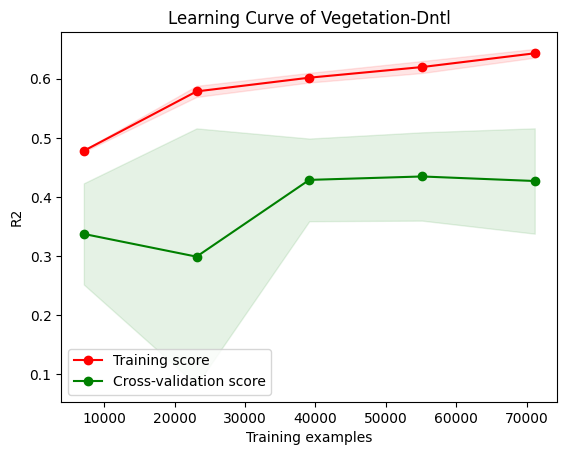

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [ ]:
#定义绘图函数
from sklearn.model_selection import learning_curve
def plot_learning_curve(model, X, y, cv=10):
  train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, scoring='r2')
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.figure()
  plt.title(f'Learning Curve of Vegetation-Dntl')
  plt.xlabel('Training examples')
  plt.ylabel('R2')
  plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                   train_scores_mean + train_scores_std, alpha=0.1,
                   color='r')
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                   test_scores_mean + test_scores_std, alpha=0.1, color='g')
  plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
           label='Training score')
  plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
           label='Cross-validation score')
  plt.legend(loc='best')
  plt.show()


# 使用LightGBM绘制Dntl的学习曲线
plot_learning_curve(best_lgb_QT_DNTL, X, y)


plt.savefig('/content/drive/MyDrive/data/qt_dntl_learning_curve.png', dpi=300, bbox_inches='tight')
from google.colab import files
files.download('/content/drive/MyDrive/data/qt_dntl_learning_curve.png')

# 5.调用LightGBM模型，使用训练集数据进行训练（拟合）
# Add verbosity=2 to print messages while running boosting
my_model = best_lgb_QT_DNTL

In [13]:
# 定义LightGBM回归器，并设置参数
my_model = lgb.LGBMRegressor(
    colsample_bytree = 0.5135402088882496,
    learning_rate = 0.018533499373170944,
    max_depth = 12,
    min_child_samples = 10,
    n_estimators = 984,
    num_leaves = 255,
    reg_alpha = 0.7497096191104269,
    reg_lambda = 0.4143027383331399,
    subsample = 0.5562448559470744,
    random_state = 42 # 设置随机种子，保证结果可复现
)

# 6.使用fit函数拟合
my_model.fit(train_X, train_y)
a=my_model.score(test_X,test_y)
print("my_model_score:",a)

# 7.保存模型，并打分
joblib.dump(my_model,"my_model_cz.dat")
a=my_model.score(test_X,test_y)
print("my_model_score:",a)
# 8.加载模型，并打分
load_model = joblib.load("my_model_cz.dat")
b=load_model.score(test_X,test_y)
print("load_model_score:",b)
# 9.使用my_model对测试集数据进行预测预测
print('开始预测...')
y_pred = my_model.predict(test_X, num_iteration=my_model.best_iteration_)

# 对测试集进行预测
load_pred = load_model.predict(test_X)
# 计算评估指标
rmse = np.sqrt(mean_squared_error(test_y, y_pred))
r2 = r2_score(test_y, y_pred)
me = mean_absolute_error(test_y, y_pred)
# 打印评估指标
print(f'RMSE for NC_DNTL: {rmse}')
print(f'R2 for NC_DNTL: {r2}')
print(f'ME for NC_DNTL: {me}')

# 对训练集进行预测
load_pred = load_model.predict(train_X, num_iteration=load_model.best_iteration_)
# 计算评估指标
rmse = np.sqrt(mean_squared_error(train_y, load_pred))
r2 = r2_score(train_y, load_pred)
me = mean_absolute_error(train_y, load_pred)
# 打印评估指标
print(f'RMSE for train_DNTL: {rmse}')
print(f'R2 for train_DNTL: {r2}')
print(f'ME for train_DNTL: {me}')



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4036
[LightGBM] [Info] Number of data points in the train set: 63232, number of used features: 19
[LightGBM] [Info] Start training from score -0.310559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

预测结果的rmse是:
0.4115619806274409
Mean Absolute Error : 0.24070997006878145
r2_score : 
0.4986589397230483
Feature importances: [17010, 21761, 18180, 17346, 5118, 12378, 6820, 19394, 19421, 14267, 10855, 5655, 10214, 8046, 10565, 8890, 19384, 20187, 2545]
       feature  importance
0         Rntl       17010
1           ND       21761
2          DEM       18180
3          GDP       17346
4         LUCC        5118
5           RD       12378
6           WD        6820
7           PD       19394
8           SL       19421
9           DR       14267
10     wind918       10855
11     prec918        5655
12      MWS_3D       10214
13      AWS_3D        8046
14      MPP_3D       10565
15      APP_3D        8890
16    NDVI_Aug       19384
17  NDVI(9_10)       20187
18          SD        2545
       feature  importance
18          SD        2545
4         LUCC        5118
11     prec918        5655
6           WD        6820
13      AWS_3D        8046
15      APP_3D        8890
12      MWS_3D    

<ipython-input-15-de1278218e65>:24: FutureWarning: `sort_columns` is deprecated and will be removed in a future version.
  df_fi.head(top).plot(kind='barh',


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1920x1440 with 0 Axes>

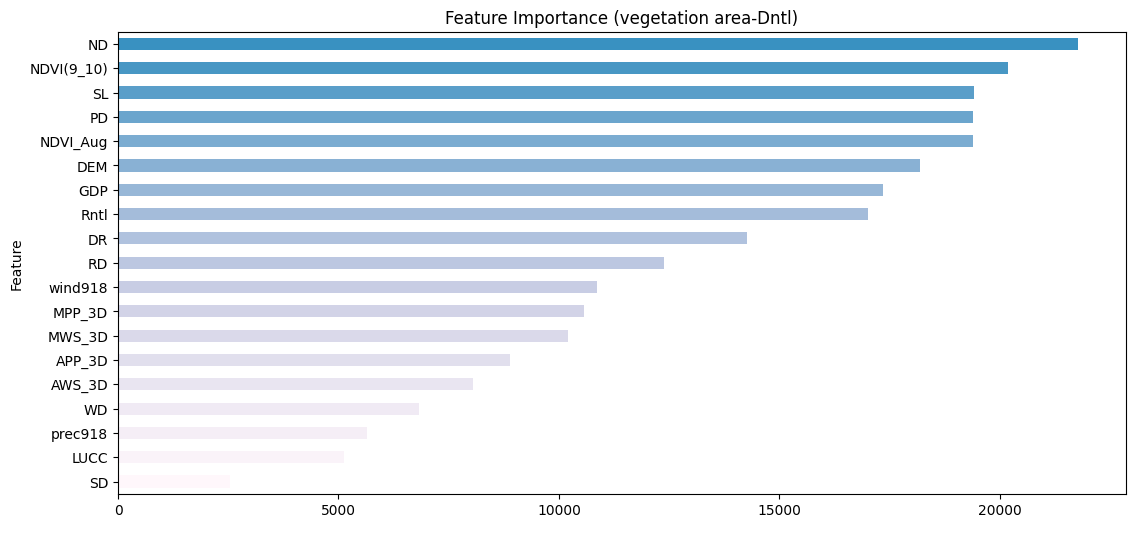

In [15]:
# 9.1.评估预测结果（RMSE,ME，R方）
# 9.1.1 RMSE
print('预测结果的rmse是:')
print(mean_squared_error(test_y, y_pred) ** 0.5)
# 9.1.2 ME（平均绝对误差）
print("Mean Absolute Error : " + str(mean_absolute_error(y_pred, test_y)))
# 9.1.3 R方（相关系数）
print("r2_score : ")
print(r2_score(test_y, y_pred))
# 特征重要度
print('Feature importances:', list(my_model.feature_importances_))
feature_importance = my_model.feature_importances_
#方法一画特征重要性图
data_feature = {'feature': ['Rntl', 'ND', 'DEM', 'GDP', 'LUCC', 'RD', 'WD', 'PD', 'SL', 'DR', 'wind918', 'prec918', 'MWS_3D', 'AWS_3D', 'MPP_3D', 'APP_3D', 'NDVI_Aug', 'NDVI(9_10)', 'SD'],
        'importance': (feature_importance)}#创建数据,文本和单独的数字用['']表示，存有数据的对象用()才能够顺利读取到上面文本对应的每一个格子！
df_fi = pd.DataFrame(data_feature)
print(df_fi)
df_fi.sort_values(by=['importance'],axis=0,ascending=True,inplace=True)
print(df_fi)

top = 30
# 创建图形
plt.figure(1, dpi=300) # 增加dpi参数提高图像清晰度
df_fi.head(top).plot(kind='barh',
                     x='feature',
                     y='importance',
                     sort_columns=True,
                     legend=False,
                     figsize=(13, 6),
                     color=plt.cm.PuBu(np.linspace(0, 1, top), alpha=1))
                     # 使用渐变色彩映射改变柱状图的配色 color=plt.cm.viridis(np.linspace(0, 1, top))
plt.title('Feature Importance (vegetation area-Dntl)', fontname='Times New Roman')
plt.xlabel(' ')
plt.ylabel('Feature', fontname='Times New Roman')
plt.savefig('/content/drive/MyDrive/data/qt_dntl_import.png', dpi=300, bbox_inches='tight')
from google.colab import files
files.download('/content/drive/MyDrive/data/qt_dntl_import.png')

In [ ]:
# 导入PyALE模块
import PyALE
import matplotlib

# 定义你的19个特征的列表
#features = ['Rntl', 'ND', 'DEM', 'GDP', 'RD', 'WD', 'PD', 'SL', 'DR', 'wind918', 'prec918',
#           'MWS_3D', 'AWS_3D', 'MPP_3D', 'APP_3D', 'Landuse', 'NDVI_Aug', 'NDVI(9_10)', 'SD']

# 为每个特征创建一个字典，存储它们的单位，例如米、百分比等，根据您的数据类型选择合适的单位
units = {'Rntl': '/', 'ND': 'm', 'DEM': 'm', 'GDP': 'milion/km\u00B2', 'RD': 'km/km\u00B2', 'WD': 'km/km\u00B2', 'PD': 'per/km\u00B2',
         'SL': 'degree', 'DR': 'km', 'wind918': 'm/s', 'prec918': '0.01mm', 'MWS_3D': 'm/s', 'AWS_3D': 'm/s', 'MPP_3D': '0.01mm',
         'APP_3D': '0.01mm', 'NDVI_Aug': '/', 'NDVI(9_10)': '/', 'SD': 'per/km\u00B2','LUCC':'/'}

# 使用Unicode字符实现上标效果
for feature, unit in units.items():
  print(feature, unit)

# 定义一个name属性给您的模型，赋值为您想要的模型名
my_model.name = 'QT_Dntl'

# 定义一个feature_type字典，指定特征的类型
feature_type = {'Dntl': 'continuous', 'ND': 'continuous', 'DEM': 'continuous', 'GDP': 'continuous', 'RD': 'continuous', 'WD': 'continuous', 'PD': 'continuous',
         'SL': 'continuous', 'DR': 'continuous', 'wind918': 'continuous', 'prec918': 'continuous', 'MWS_3D': 'continuous', 'AWS_3D': 'continuous', 'MPP_3D': 'continuous',
         'APP_3D': 'continuous', 'NDVI_Aug': 'continuous', 'NDVI(9_10)': 'continuous', 'SD': 'continuous','LUCC':'discrete'}


# 循环遍历每个特征，绘制并保存ALE图
for feature in feature_list:
  # 计算并绘制ALE图
  ale_eff = ale(X, model=my_model, feature=[feature], grid_size=20, include_CI=True, C=0.95)
  # 使用plt.title()函数去掉标题，指定label参数为空字符串
  plt.title(label='')
  # 从字典中获取相应的单位，并添加到坐标轴的标签中
  plt.xlabel(feature + ' (' + units[feature] + ')')
  plt.ylabel('Predicted Dntl')
  # 或者使用plt.gcf().findobj()函数查找当前图像中的线条对象
  lines = plt.gcf().findobj(matplotlib.lines.Line2D)
  # 遍历线条对象，设置颜色为黑色
  for line in lines:
    line.set_color('black')
  # 使用plt.gca().set_facecolor()函数设置图像的背景颜色为浅灰色
  plt.gca().set_facecolor('lightgray')
  # 使用plt.gca().spines属性隐藏边框
  ax = plt.gca()
  ax.spines['top'].set_color('none')
  ax.spines['bottom'].set_color('none')
  ax.spines['left'].set_color('none')
  ax.spines['right'].set_color('none')
  # 使用plt.gca().set_facecolor()函数设置背景颜色为浅灰色
  ax.set_facecolor('#E6E6E6')
  # 使用plt.gca().grid()函数添加白色的稀疏的网格线
  ax.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.8)
    # 使用plt.axhline()函数在y=0处加一条深灰色的虚线
  plt.axhline(y=0, color='darkgray', linestyle='--',linewidth=1.0,)
  # 使用plt.suptitle()函数去掉标题，指定t参数为空字符串
  plt.suptitle(t='')
  # 调整图像的大小，使其符合的比例
  plt.gcf().set_size_inches(6, 5)
  #保存ALE图到你的Google Drive，文件名为模型名_特征名_ALE.png
  plt.savefig('/content/drive/MyDrive/data/{}_{}_ALE_0.95.png'.format(my_model.name, feature), dpi=300, bbox_inches='tight')
  #下载ALE图到你的电脑，文件名同上
  from google.colab import files
  files.download('/content/drive/MyDrive/data/{}_{}_ALE_0.95.png'.format(my_model.name, feature))



INFO:PyALE._ALE_generic:Continuous feature detected.


Rntl /
ND m
DEM m
GDP milion/km²
RD km/km²
WD km/km²
PD per/km²
SL degree
DR km
wind918 m/s
prec918 0.01mm
MWS_3D m/s
AWS_3D m/s
MPP_3D 0.01mm
APP_3D 0.01mm
NDVI_Aug /
NDVI(9_10) /
SD per/km²
LUCC /


In [ ]:
# 导入PyALE模块
import PyALE

# 定义你的14个特征的列表
features = ['Rntl', 'ND', 'DEM', 'GDP', 'LUCC', 'NDVI', 'RD', 'WD', 'PD', 'SL', 'DR', 'MWS_3D', 'AWS_3D', 'MPP_3D', 'APP_3D']

# 循环遍历每个特征，绘制并保存ALE图
for feature in features:
  # 计算并绘制ALE图
  ale_eff = PyALE.ale(my_model, X, features=[feature], grid_size=50, include_CI=True, C=0.95)
  # 保存ALE图到你的Google Drive，文件名为模型名_特征名_ALE.png
  plt.savefig('/content/drive/MyDrive/data/{}_{}_ALE.png'.format(my_model.name, feature), dpi=300, bbox_inches='tight')
  # 下载ALE图到你的电脑，文件名同上
  from google.colab import files
  files.download('/content/drive/MyDrive/data/{}_{}_ALE.png'.format(my_model.name, feature))


In [ ]:
ale_eff = ale(X, model=my_model, feature=["RD"], grid_size=20, include_CI=True, C=0.95)

##dis
ale_eff = ale(X, model=my_model, feature=["AWS_3D"], grid_size=20, include_CI=True, C=0.95)


##dem
ale_eff = ale(X, model=my_model, feature=["ND"], grid_size=20, include_CI=True, C=0.95)

